# How to run ONNX Inference

In [123]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from mobile_sam import sam_model_registry, SamPredictor
from mobile_sam.utils.onnx import SamOnnxModel

import onnxruntime

def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

image = cv2.imread('images/potatoes.png')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


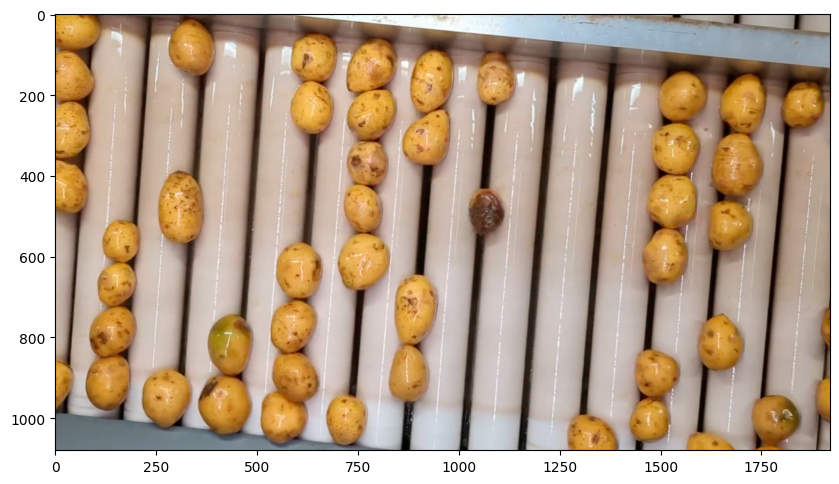

In [124]:
plt.figure(figsize=(10,10))
plt.imshow(image_rgb)
plt.axis('on')
plt.show()

In [125]:
preprocessing_path = "../weights/mobile_sam_encoder_tinyvit_preprocessor.onnx"
encoder_path = "../weights/mobile_sam_encoder_tinyvit.onnx"
decoder_path = "../weights/mobile_sam_decoder.onnx"

preprocessing_onnx = onnxruntime.InferenceSession(preprocessing_path)
encoder_onnx = onnxruntime.InferenceSession(encoder_path)
decoder_onnx = onnxruntime.InferenceSession(decoder_path)

In [126]:
input_point = np.array([[180, 660]])
input_label = np.array([1])

In [127]:
preprocessed_image = preprocessing_onnx.run(None, {"image": image})[0]

In [128]:
preprocessed_image.shape

(1, 3, 1024, 1024)

In [129]:
image_embeddings = encoder_onnx.run(None, {"preprocessed_image": preprocessed_image})[0]

In [130]:
image_embeddings.shape

(1, 256, 64, 64)

In [131]:
def apply_coords(coords: np.ndarray, original_size: tuple[int, ...]) -> np.ndarray:
    """
    Expects a numpy array of length 2 in the final dimension. Requires the
    original image size in (H, W) format.
    """
    old_h, old_w = original_size
    new_h, new_w = (576, 1024)
    coords = coords.copy().astype(float)
    coords[..., 0] = coords[..., 0] * (new_w / old_w)
    coords[..., 1] = coords[..., 1] * (new_h / old_h)
    return coords

onnx_coord = np.zeros((128, 2))
onnx_coord[0] = [0, 0] # This is reserved for background and should not be used!
onnx_coord[1] = [180, 660]
onnx_coord[2] = [342, 43]

onnx_coord = apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)


In [132]:
ort_inputs = {
    "image_embeddings": image_embeddings,
    "point_coords": onnx_coord,
    "orig_im_size": np.array(image.shape[:2], dtype=np.int32)
}

In [133]:
np.array(image.shape[:2], dtype=np.float32).shape

(2,)

In [134]:
masks_all = decoder_onnx.run(None, ort_inputs)[0]

In [135]:
masks = (masks_all == 0)

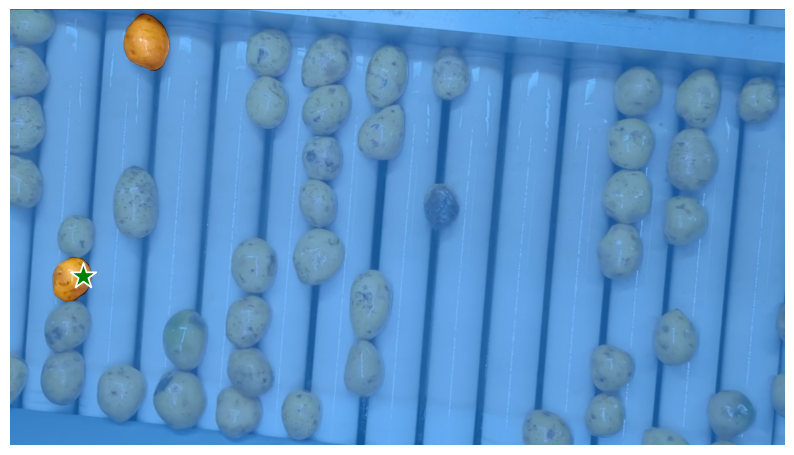

In [136]:
plt.figure(figsize=(10,10))
plt.imshow(image_rgb)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()